# Installing packages

In [2]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from scipy.optimize import minimize
from scipy.stats.stats import pearsonr  
from scipy import stats
from sklearn.metrics import r2_score
from itertools import combinations

%load_ext rpy2.ipython

/var/folders/ww/jwc_dkyx4_58jw9lnh79r69r0000gn/T/ipykernel_1965/4259127624.py:6: DeprecationWarning: Please import `pearsonr` from the `scipy.stats` namespace; the `scipy.stats.stats` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.stats.stats import pearsonr


In [3]:
%%R  -w 8 -h 3 #--units in -r 200
##installing packages and setting options for the plots in R

# {r settings, echo=F, message=F, error=F}
knitr::opts_chunk$set(echo = F)
if (!require("pacman")) install.packages("pacman")
pacman::p_load(ggplot2, patchwork, cowplot, tidyverse, devtools, ggrepel, ggh4x, officer, rvg, svglite, install = T)

# # Required on the first run, comment afterward?
devtools::install_github("BlakeRMills/MoMAColors")
library(MoMAColors)

theme_set(theme_cowplot() +
          theme(text = element_text(size=9),
                axis.text = element_text(size=9),
                panel.grid.major.x = element_blank() ,
                panel.grid.major.y = element_line( linewidth=.1, color="black")))

Loading required package: pacman
Skipping install of 'MoMAColors' from a github remote, the SHA1 (6f5d75de) has not changed since last install.
  Use `force = TRUE` to force installation


# Inter-languages correlations

In [17]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
pivot_df = data.pivot(columns='lang', values='log_freq', index='number')
pivot_df.drop('en_arabic_numerals', axis=1, inplace=True)
# Compute the correlation matrix between languages
correlation_matrix = pivot_df.corr()

# Display the correlation matrix
print((correlation_matrix))
print((correlation_matrix[['de', 'en', 'es', 'fr', 'it', 'mean', 'ru']].min().min()))

lang        de        en        es        fr        it      mean        ru
lang                                                                      
de    1.000000  0.993320  0.983140  0.992603  0.987790  0.996579  0.985443
en    0.993320  1.000000  0.981457  0.992674  0.988204  0.996571  0.987797
es    0.983140  0.981457  1.000000  0.981839  0.977829  0.988744  0.976166
fr    0.992603  0.992674  0.981839  1.000000  0.989281  0.996761  0.988672
it    0.987790  0.988204  0.977829  0.989281  1.000000  0.993703  0.983316
mean  0.996579  0.996571  0.988744  0.996761  0.993703  1.000000  0.992744
ru    0.985443  0.987797  0.976166  0.988672  0.983316  0.992744  1.000000
0.9761661480937414


# Linear regressions

### Using only log10

In [13]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
df = data[data.lang.isin(['en'])]
y = np.array(df['log_freq'])
X = np.array(df['log10'])
X = sm.add_constant(X)
numbers = [i+1 for i in range(99)]
# Fit the model
model = sm.OLS(y, X).fit()
predictions = model.predict(X)
R2 = model.rsquared
preds = {
    'number':numbers,
    'log_freq': y,
    'predictions':predictions,
    'R2':[R2]*len(numbers)
}
df2 = pd.DataFrame(preds)
df2.to_csv('temp.csv')

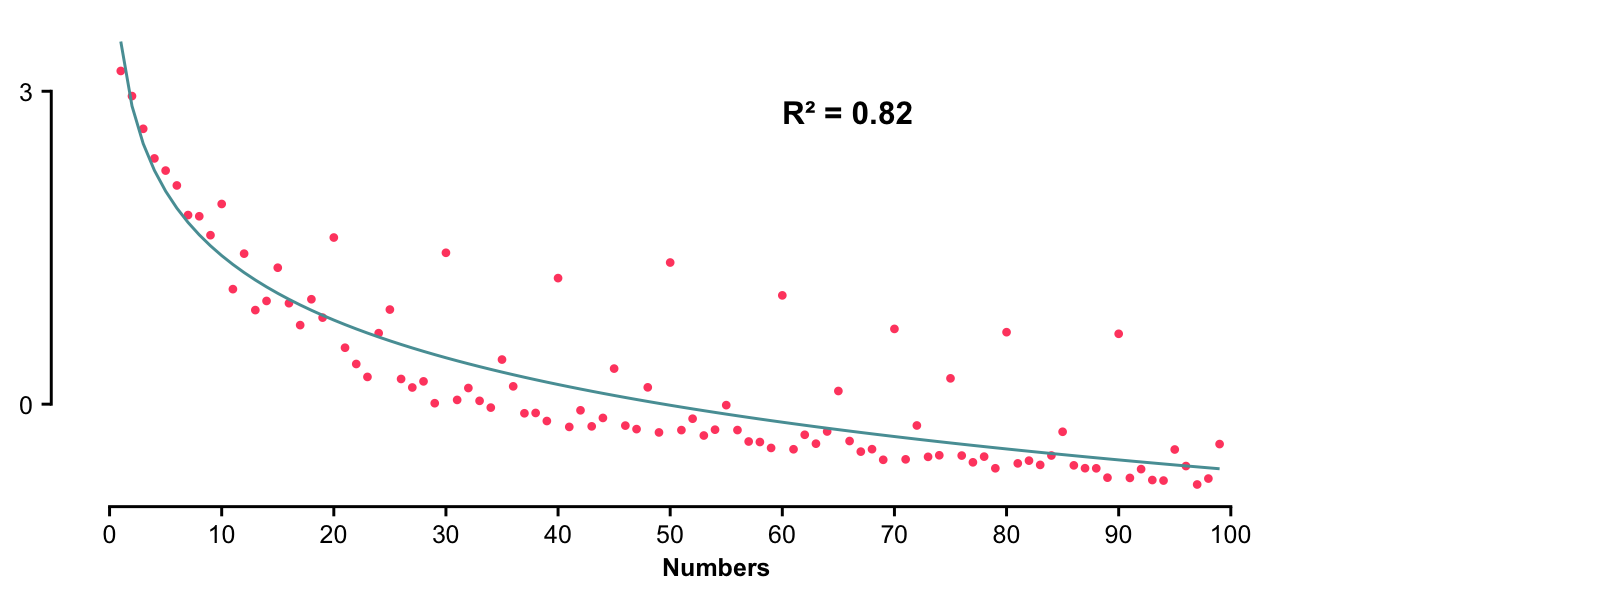

In [14]:
%%R  -w 8 -h 3 --units in -r 200
data <- read.csv('temp.csv')
R2 <- round(data$R2[1],2)
pl2 <- data %>%
    ggplot(aes(x = number)) +
    geom_point(aes(y = log_freq, color='line'),size=0.8) +
    geom_line(aes(y = predictions, color='point'), linewidth=0.5) +
    annotate("text", x = 60, y = 2.8, label = paste("R² =", R2), size = 4, hjust = 0, fontface = "bold") +

    theme(legend.position = "none",
        axis.title.y=element_blank(),
        panel.grid.major.y = element_blank(),
        axis.title.x = element_text(face="bold", size=9, hjust=0.43, family='Arial')) +
    labs(x = "Numbers") +
    scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave("plots/2A_regression_onlylog10.svg", pl2, device='svg',width = 8, height = 3, units = "in")
pl2


### Using all predictors

In [9]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
df = data[data.lang.isin(['en'])]
y = np.array(df['log_freq'])
X1 = np.array(df['log10'])
X1 = sm.add_constant(X1)
X2 = np.array(df[['log10', 'mult2', 'mult3','mult5', 'mult10']])
X2 = sm.add_constant(X2)
numbers = [i+1 for i in range(99)]
# Fit the model
model1 = sm.OLS(y, X1).fit()
predictions1 = model1.predict(X1)
R21 = model1.rsquared
print(model1.summary())
# Fit the model
model2 = sm.OLS(y, X2).fit()
predictions2 = model2.predict(X2)
R22 = model2.rsquared
print(model2.summary())
preds = {
    'number':numbers,
    'log_freq': y,
    'predictions_log10':predictions1,
    'predictions_all':predictions2,
    'R2':[R21, R22] + [0]*(len(numbers)-2)
}
df2 = pd.DataFrame(preds)
df2.to_csv('temp.csv')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     442.0
Date:                Fri, 13 Dec 2024   Prob (F-statistic):           6.71e-38
Time:                        15:28:49   Log-Likelihood:                -46.082
No. Observations:                  99   AIC:                             96.16
Df Residuals:                      97   BIC:                             101.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.4768      0.159     21.906      0.0

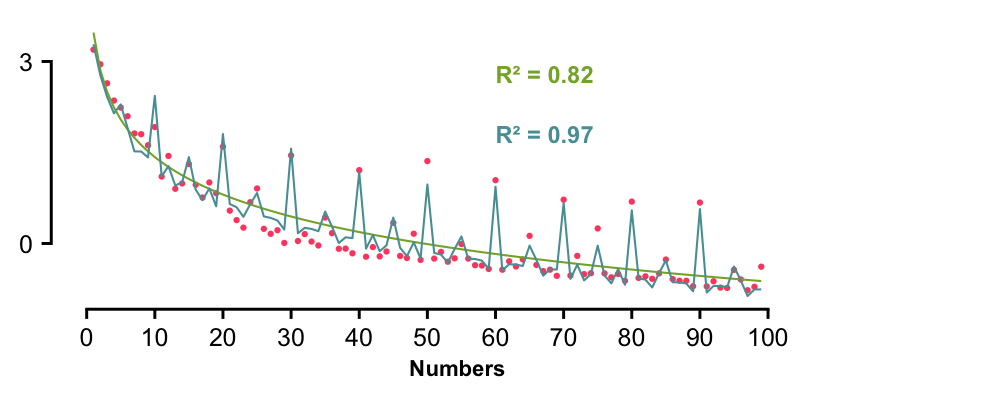

In [12]:
%%R  -w 5 -h 2 --units in -r 200
data <- read.csv('temp.csv')
R21 <- round(data$R2[1],2) 
R22 <- round(data$R2[2],2)
c1 = moma.colors('Klein',7)[1]
c2 = moma.colors('Klein',7)[2]
c3 = moma.colors('Klein',7)[5]
pl3 <- data %>%
    ggplot(aes(x = number)) +
    geom_point(aes(y = log_freq, color=c1),size=0.4, color=c1) +
    geom_line(aes(y = predictions_log10, color=c2), linewidth=0.35, color=c3) +
    geom_line(aes(y = predictions_all, color=c3), linewidth=0.35, color=c2) +

    annotate("text", x = 60, y = 2.8, label = paste("R² =", R21), size = 3, hjust = 0, fontface = "bold", color=c3) +
    annotate("text", x = 60, y = 1.8, label = paste("R² =", R22), size = 3, hjust = 0, fontface = "bold", color=c2) +

    theme(legend.position = "none",
        axis.title.y=element_blank(),
        panel.grid.major.y = element_blank(),
        axis.title.x = element_text(face="bold", size=8, hjust=0.43, family='Arial')) +
    labs(x = "Numbers") +
    # scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

ggsave("plots/3_regression_log10_divisibilities.svg", pl3, device='svg',width = 8, height = 3, units = "in")
pl3


# The case of 24, 26, 34, 36

In [4]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

group_24 = np.array(data[data['number'].isin([24])].log_freq)
group_26 = np.array(data[data['number'].isin([26])].log_freq)
group_34 = np.array(data[data['number'].isin([34])].log_freq)
group_36 = np.array(data[data['number'].isin([36])].log_freq)

t_stat1, p_value1 = stats.ttest_1samp(group_24 - group_26, popmean=0)
t_stat2, p_value2 = stats.ttest_1samp(group_34 - group_36, popmean=0)

print(f"For 24/26 t-statistic: {t_stat1}, pvalue = {p_value1}")
print(f"For 34/36 t-statistic: {t_stat2}, pvalue = {p_value2}")

For 24/26 t-statistic: 7.580537498678892, pvalue = 0.00012834626086271204
For 34/36 t-statistic: -6.915028440386469, pvalue = 0.00022822863327726504


[1] 1.687084e-05


R[write to console]: In addition: 
R[write to console]: Warning messages:

R[write to console]: 1: 
R[write to console]: In geom_segment(aes(x = 1, xend = 2, y = 1.35, yend = 1.35), size = 0.3) :
R[write to console]: 
 
R[write to console]:  All aesthetics have length 1, but the data has 7 rows.
ℹ Did you mean to use `annotate()`?

R[write to console]: 2: 
R[write to console]: In geom_segment(aes(x = 1, xend = 1, y = 1.35, yend = 1.32), size = 0.3) :
R[write to console]: 
 
R[write to console]:  All aesthetics have length 1, but the data has 7 rows.
ℹ Did you mean to use `annotate()`?

R[write to console]: 3: 
R[write to console]: In geom_segment(aes(x = 2, xend = 2, y = 1.35, yend = 1.32), size = 0.3) :
R[write to console]: 
 
R[write to console]:  All aesthetics have length 1, but the data has 7 rows.
ℹ Did you mean to use `annotate()`?

R[write to console]: 4: 
R[write to console]: In geom_segment(aes(x = 2.5, xend = 3.5, y = 1.35, yend = 1.35),  :
R[write to console]: 
 
R[write to

In addition: Warning messages:
1: In geom_segment(aes(x = 1, xend = 2, y = 1.35, yend = 1.35), size = 0.3) :
  All aesthetics have length 1, but the data has 7 rows.
ℹ Did you mean to use `annotate()`?
2: In geom_segment(aes(x = 1, xend = 1, y = 1.35, yend = 1.32), size = 0.3) :
  All aesthetics have length 1, but the data has 7 rows.
ℹ Did you mean to use `annotate()`?
3: In geom_segment(aes(x = 2, xend = 2, y = 1.35, yend = 1.32), size = 0.3) :
  All aesthetics have length 1, but the data has 7 rows.
ℹ Did you mean to use `annotate()`?
4: In geom_segment(aes(x = 2.5, xend = 3.5, y = 1.35, yend = 1.35),  :
  All aesthetics have length 1, but the data has 7 rows.
ℹ Did you mean to use `annotate()`?
5: In geom_segment(aes(x = 2.5, xend = 2.5, y = 1.35, yend = 1.32),  :
  All aesthetics have length 1, but the data has 7 rows.
ℹ Did you mean to use `annotate()`?
6: In geom_segment(aes(x = 3.5, xend = 3.5, y = 1.35, yend = 1.32),  :
  All aesthetics have length 1, but the data has 7 rows.


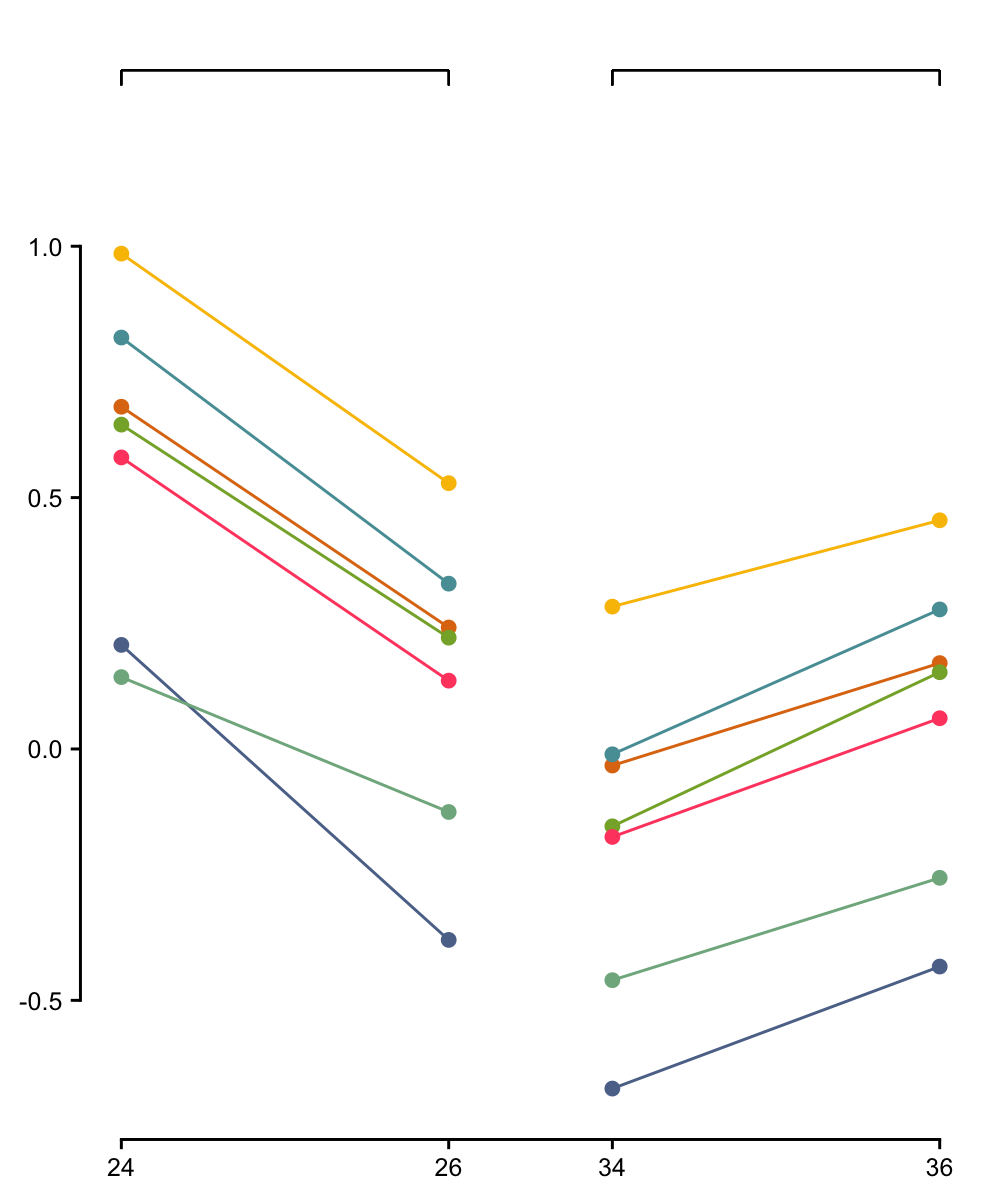

In [8]:
%%R  -w 5 -h 6 --units in -r 200
df <- read.csv("data_ngram_allLangsPerMilion.csv")%>% filter(lang !=  'en_arabic_numerals')
df <- df[df$number %in% c(24,26,34,36),][,c('number',"log_freq","lang")]
df <- pivot_wider(df, names_from = number, values_from = log_freq) %>%  as.data.frame()
p_value_24_26 <- t.test(df[,'24'], df[,'26'], paired = TRUE, alternative = "two.sided")$p.value
p_value_34_36 <- t.test(df[,'34'], df[,'36'], paired = TRUE, alternative = "two.sided")$p.value

print(p_value_24_26)
pl1 <- ggplot(df %>%
  mutate(nicelang =
         case_when(
          lang == "mean" ~ "Average",
          lang == "fr" ~ "French",
          lang == "en" ~ "English",
          lang == "it" ~ "Italian",
          lang == "de" ~ "German",
          lang == "es" ~ "Spanish",
          lang == "ru" ~ "Russian",
          
          )) %>%
  mutate(nicelang = factor(nicelang, levels=c('Average',"French", "English", "Spanish", "Italian", "German", "Russian")))) +
  geom_segment(aes(x = 1, xend = 2, y = `24`, yend = `26`, color = nicelang)) +
  geom_point(aes(x = 1, y = `24`, color = nicelang), size = 2) + 
  geom_point(aes(x = 2, y = `26`, color = nicelang), size = 2) +
  geom_segment(aes(x = 2.5, xend = 3.5, y = `34`, yend = `36`, color = nicelang)) +
  geom_point(aes(x = 2.5, y = `34`, color = nicelang), size = 2) + 
  geom_point(aes(x = 3.5, y = `36`, color = nicelang), size = 2) +
  scale_x_continuous(breaks = c(1, 2, 3, 4), labels = c("24", "26","34", "36")) +
  # annotate("text", x = 1, y = 1.4, label = paste("p =", formatC(p_value_24_26, format = "e", digits = 2)), size = 2, hjust = 0, fontface = "bold") +
  geom_segment(aes(x = 1, xend = 2, y = 1.35, yend = 1.35), size = 0.3) +
  geom_segment(aes(x = 1, xend = 1, y = 1.35, yend = 1.32), size = 0.3) +  
  geom_segment(aes(x = 2, xend = 2, y = 1.35, yend = 1.32), size = 0.3) +

  # annotate("text", x = 2.5, y = 1.4, label = paste("p =", formatC(p_value_34_36, format = "e", digits = 2)), size = 2, hjust = 0, fontface = "bold") +
  geom_segment(aes(x = 2.5, xend = 3.5, y = 1.35, yend = 1.35), size = 0.3) +
  geom_segment(aes(x = 2.5, xend = 2.5, y = 1.35, yend = 1.32), size = 0.3) +  
  geom_segment(aes(x = 3.5, xend = 3.5, y = 1.35, yend = 1.32), size = 0.3) +

  # annotate(aes(x = 3.7, y=0.5,label = nicelang, color = nicelang), size=4, nudge_x = 4, na.rm = TRUE) +
  theme(legend.position = "none",
      axis.title.y=element_blank(),
      panel.grid.major.y = element_blank(),
      axis.title.x = element_blank()) +
  scale_color_manual(values=moma.colors("Klein")) +
  # theme(legend.position = "right", legend.title = element_blank()) +
  guides(x = guide_axis_manual(trunc_lower=1, trunc_upper=3.5, breaks=c(1, 2, 2.5, 3.5)),
         y = guide_axis_manual(trunc_lower=-0.5, trunc_upper=1, breaks=seq(-0.5,1,0.5)))

# pl2 <- ggplot(df %>%
#   mutate(nicelang =
#          case_when(
#           lang == "mean" ~ "Average",
#           lang == "fr" ~ "French",
#           lang == "en" ~ "English",
#           lang == "it" ~ "Italian",
#           lang == "de" ~ "German",
#           lang == "es" ~ "Spanish",
#           lang == "ru" ~ "Russian",
          
#           )) %>%
#   mutate(nicelang = factor(nicelang, levels=c('Average',"French", "English", "Spanish", "Italian", "German", "Russian")))) +
#   geom_segment(aes(x = 1, xend = 2, y = `34`, yend = `36`, color = nicelang)) +
#   geom_point(aes(x = 1, y = `34`, color = nicelang), size = 2) + 
#   geom_point(aes(x = 2, y = `36`, color = nicelang), size = 2) +
#   scale_x_continuous(breaks = c(1, 2), labels = c("34", "36")) +
#   annotate("text", x = 1.4, y = 0.6, label = paste("p =", formatC(p_value_34_36, format = "e", digits = 2)), size = 2, hjust = 0, fontface = "bold") +
#   geom_segment(aes(x = 1, xend = 2, y = 0.55, yend = 0.55), size = 0.3) +
#   geom_segment(aes(x = 1, xend = 1, y = 0.55, yend = 0.52), size = 0.3) +  
#   geom_segment(aes(x = 2, xend = 2, y = 0.55, yend = 0.52), size = 0.3) +
#   theme(legend.position = "none",
#       axis.title.y=element_blank(),
#       panel.grid.major.y = element_blank(),
  #     axis.title.x = element_blank()) +
  # scale_color_manual(values=moma.colors("Klein")) +
  # theme(legend.position = "right", legend.title = element_blank()) +
  # guides(x = guide_axis_manual(trunc_lower=1, trunc_upper=2, breaks=c(1, 2)),
  #        y = guide_axis_manual(trunc_lower=-0.5, trunc_upper=0.5, breaks=c(-0.5, 0, 0.5)))

ggsave(filename = "plots/2_24_26_analysis.svg", device='svg', plot = pl1 , width = 3, height = 4)

pl1 

# Importance of different variables in the regression

In [3]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
df = data[data.lang.isin(['en'])]

# List of features to consider
features = ['mult2', 'mult3', 'mult5', 'mult7', 'mult10']

y = np.array(df['log_freq'])

# Initial model with just the intercept and 'log10'
X_base = sm.add_constant(df[['log10']])
model = sm.OLS(y, X_base).fit()

# Track results for each step
stepwise_results = []
used_features = []

# Stepwise feature selection
for step in range(len(features)):
    best_p_value = float('inf')
    best_feature = None
    best_model = None
    best_R2 = None
    best_beta = None
    best_p = None

    # Iterate over remaining features not yet added to the model
    for feature in features:
        if feature not in used_features:
            # Add the current feature to the base model
            X_temp = sm.add_constant(df[['log10'] + used_features + [feature]])
            temp_model = sm.OLS(y, X_temp).fit()

            # Get the p-value of the newly added feature
            p_value = temp_model.pvalues[feature]

            # If the p-value is the best so far, update the best feature
            if p_value < best_p_value:
                best_p_value = p_value
                best_feature = feature
                best_model = temp_model
                best_R2 = temp_model.rsquared
                best_beta = temp_model.params[feature]
                best_p = p_value

    if best_feature is not None:
        # Add the best feature to the used list
        used_features.append(best_feature)

        # Store the results for this step
        stepwise_results.append({
            'Step': step + 1,
            'Feature': best_feature,
            'R2': best_R2,
            'Beta': best_beta,
            'P-value': best_p
        })

        # Print the results of this step
        print(f"Step {step + 1}: Added {best_feature}, R2: {best_R2:.4f}, Beta: {best_beta:.4f}, P-value: {best_p:.4e}")

Step 1: Added mult10, R2: 0.9484, Beta: 1.1327, P-value: 8.9727e-28
Step 2: Added mult5, R2: 0.9661, Beta: 0.4043, P-value: 2.6703e-10
Step 3: Added mult3, R2: 0.9704, Beta: 0.1253, P-value: 4.1748e-04
Step 4: Added mult2, R2: 0.9738, Beta: 0.1179, P-value: 7.8795e-04
Step 5: Added mult7, R2: 0.9738, Beta: -0.0041, P-value: 9.2677e-01


# Checking if multiplicity is better than divisibility

In [10]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

df = data[data.lang.isin(['es'])]

two_words_numbers_list = [i for i in range(21,100) if i%10!=0]
df = df[df.number.isin(two_words_numbers_list)]


# Lists of features to use in the regression

features = ['mult10', 'mult5', 'mult3', 'mult2']
features2 = ['exp10', 'exp5', 'exp3', 'exp2']

y = np.array(df['log_freq'])

X1 = np.array(df[['log10'] + features])
X1 = sm.add_constant(X1)  
X2 = np.array(df[['log10'] + features2])
X2 = sm.add_constant(X2)

model1 = sm.OLS(y, X1).fit()
model2 = sm.OLS(y, X2).fit()
predictions = model1.predict(X1)
numbers = [i+1 for i in range(99)]

print(model1.summary())
preds = {
    'number':two_words_numbers_list,
    'log_freq': y,
    'predictions':predictions,
    # 'R2':[R2]*len(numbers)
}
df2 = pd.DataFrame(preds)
df2.to_csv('temp.csv')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.774
Method:                 Least Squares   F-statistic:                     61.66
Date:                Tue, 29 Oct 2024   Prob (F-statistic):           9.53e-22
Time:                        18:10:12   Log-Likelihood:                 48.161
No. Observations:                  72   AIC:                            -86.32
Df Residuals:                      67   BIC:                            -74.94
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9971      0.142     14.080      0.0

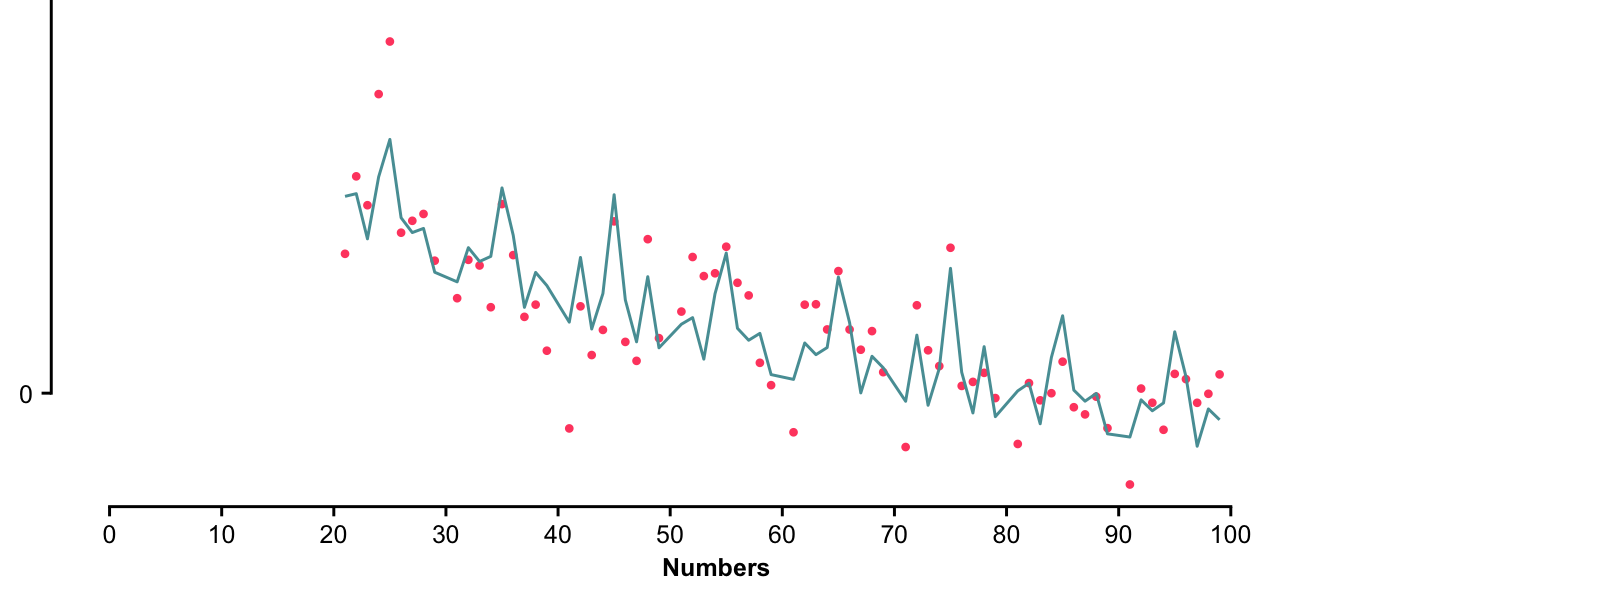

In [11]:
%%R  -w 8 -h 3 --units in -r 200
data <- read.csv('temp.csv')
# R2 <- round(data$R2[1],2)
pl2 <- data %>%
    ggplot(aes(x = number)) +
    geom_point(aes(y = log_freq, color='line'),size=0.8) +
    geom_line(aes(y = predictions, color='point'), linewidth=0.5) +
    # annotate("text", x = 60, y = 2.8, label = paste("R² =", R2), size = 4, hjust = 0, fontface = "bold") +

    theme(legend.position = "none",
        axis.title.y=element_blank(),
        panel.grid.major.y = element_blank(),
        axis.title.x = element_text(face="bold", size=9, hjust=0.43, family='Arial')) +
    labs(x = "Numbers") +
    scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=0, trunc_upper=3, breaks=c(0,3)))

# ggsave("plots/2B_regression_log10_divisibilities.svg", pl2, device='svg',width = 8, height = 3, units = "in")
pl2


In [45]:
def divisibility_vs_multiplicity(lang='en', two_words_numbers=False):
    df = data[data.lang.isin([lang])]
    if two_words_numbers:
        two_words_numbers_list = [i for i in range(21,100) if i%10!=0]
        df = df[df.number.isin(two_words_numbers_list)]


    # Lists of features to use in the regression

    features = ['mult10', 'mult5', 'mult3', 'mult2']
    features2 = ['exp10', 'exp5', 'exp3', 'exp2']
    y = np.array(df['log_freq'])

    X1 = np.array(df[['log10'] + features])
    X1 = sm.add_constant(X1)  
    X2 = np.array(df[['log10'] + features2])
    X2 = sm.add_constant(X2)

    model1 = sm.OLS(y, X1).fit()
    model2 = sm.OLS(y, X2).fit()

    # Get the R2, betas, and p-values
    R21 = model1.rsquared
    AIC1 = model1.aic
    R22 = model2.rsquared
    AIC2 = model2.aic

    results_dict = {
        'Language': lang,
        'Two-word numbers': two_words_numbers,
        'R2_divisibility': (R21),
        'AIC_divisibility': (AIC1),
        'R2_multiplicity': (R22),
        'AIC_multiplicity': (AIC2),
    }
    return pd.DataFrame(results_dict, index = [0])


# List of languages to loop through
languages = ['en','fr','it', 'de', 'es', 'ru', 'mean']



all_results = []

for lang in languages:
   all_results.append(divisibility_vs_multiplicity(lang, False))
   all_results.append(divisibility_vs_multiplicity(lang, True))

results = pd.concat(all_results)
results['Delta_AIC'] = np.array(results.AIC_multiplicity) - np.array(results.AIC_divisibility)

In [49]:
results

,Language,Two-word numbers,R2_divisibility,AIC_divisibility,R2_multiplicity,AIC_multiplicity,Delta_AIC
nicelang,,,,,,,
English,en,False,0.973766,-86.485699,0.976263,-96.385688,-9.899989
English,en,True,0.937486,-131.091185,0.952103,-150.267157,-19.175972
French,fr,False,0.976568,-76.290608,0.979096,-87.250568,-10.959961
French,fr,True,0.926571,-86.850467,0.930571,-90.715609,-3.865142
Italian,it,False,0.965023,-38.607884,0.962355,-31.331906,7.275978
Italian,it,True,0.886737,-49.588196,0.877251,-43.797812,5.790384
German,de,False,0.932310,36.729535,0.933972,34.268112,-2.461423
German,de,True,0.881284,-59.574728,0.896033,-69.126407,-9.551678
Spanish,es,False,0.940310,-44.356949,0.938480,-41.368469,2.988480


In [48]:
lang_mapping = {
    "mean": "Average",
    "fr": "French",
    "en": "English",
    "it": "Italian",
    "de": "German",
    "es": "Spanish",
    "ru": "Russian"
}

# Use .map to create the new column with mapped values
results['nicelang'] = results['Language'].map(lang_mapping)

results.set_index('nicelang', inplace=True)

# Separate the DataFrame based on the 'Two-word numbers' column
true_df = results[results['Two-word numbers'] == True].drop(columns='Two-word numbers')
false_df = results[results['Two-word numbers'] == False].drop(columns='Two-word numbers')

# Rename columns for each subset
true_df.columns = [f'True_{col}' for col in true_df.columns]
false_df.columns = [f'False_{col}' for col in false_df.columns]

# Concatenate the true and false dataframes along columns
result_df = pd.concat([true_df, false_df], axis=1)

result_df = result_df.applymap(lambda x: f"{x:.2g}" if isinstance(x, float) else x)
# Display the result
result_df.to_csv('tables/divisibility_vs_multiplicity.csv')

/var/folders/ww/jwc_dkyx4_58jw9lnh79r69r0000gn/T/ipykernel_6385/829338274.py:27: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  result_df = result_df.applymap(lambda x: f"{x:.2g}" if isinstance(x, float) else x)


# Exactly vs about

In [5]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
df = data[data.lang.isin(['en'])]
y1 = np.array(df['log_freq_about'])
y2 = np.array(df['log_freq_exactly'])
y1 = (y1-np.mean(y1))/np.std(y1)
y2 = (y2-np.mean(y2))/np.std(y2)

X = np.array(df[['log10', 'mult2', 'mult3','mult5', 'mult10']])
X = sm.add_constant(X)
numbers = [i+1 for i in range(99)]
# Fit the model
model1 = sm.OLS(y1, X).fit()
predictions1 = model1.predict(X)
R21 = model1.rsquared
print(model1.summary())

model2 = sm.OLS(y2, X).fit()
predictions2 = model2.predict(X)
R22 = model2.rsquared
print(model2.summary())


preds = {
    'number':numbers,
    'log_freq_about_normalized': y1,
    'log_freq_exactly_normalized':y2,
}
df2 = pd.DataFrame(preds)
df2.to_csv('temp.csv')

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.963
Model:                            OLS   Adj. R-squared:                  0.961
Method:                 Least Squares   F-statistic:                     487.3
Date:                Wed, 20 Nov 2024   Prob (F-statistic):           4.62e-65
Time:                        14:31:02   Log-Likelihood:                 23.032
No. Observations:                  99   AIC:                            -34.06
Df Residuals:                      93   BIC:                            -18.49
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8837      0.085     34.079      0.0

In [17]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
df = data[data.lang.isin(['en'])]
y1 = np.array(df['log_freq_about'])
y2 = np.array(df['log_freq_exactly'])
y1 = (y1-np.mean(y1))/np.std(y1)
y2 = (y2-np.mean(y2))/np.std(y2)

multiples_10 = [10*i - 1  for i in range(1, 10)]
multiples_10_plus_five = [i + 5 for i in multiples_10]

multiples_10_plus_one = [i + 1 for i in multiples_10]
multiples_10_minus_one = [i - 1 for i in multiples_10]

multiples_10_plus_three = [i + 3 for i in multiples_10]
multiples_10_plus_seven = [i + 7 for i in multiples_10]


t_stat10, p_value10 = stats.ttest_1samp((y1-y2)[multiples_10], popmean=0)
t_stat5, p_value5 = stats.ttest_1samp((y1-y2)[multiples_10_plus_five], popmean=0)

t_stat11, p_value11 = stats.ttest_1samp((y1-y2)[multiples_10_plus_one], popmean=0)
t_stat9, p_value9 = stats.ttest_1samp((y1-y2)[multiples_10_minus_one], popmean=0)

t_stat3, p_value3 = stats.ttest_1samp((y1-y2)[multiples_10_plus_three], popmean=0)
t_stat7, p_value7 = stats.ttest_1samp((y1-y2)[multiples_10_plus_seven], popmean=0)

print('multiples of 10')
print(f't = {t_stat10}, p = {p_value10}')

print('10n + 5')
print(f't = {t_stat5}, p = {p_value5}')

print('10n + 1')
print(f't = {t_stat11}, p = {p_value11}')

print('10n - 1')
print(f't = {t_stat9}, p = {p_value9}')

print('10n + 3')
print(f't = {t_stat3}, p = {p_value3}')

print('10n + 7')
print(f't = {t_stat7}, p = {p_value7}')

print(f'mean difference for the multiples of 10 in exactly vs about : {np.mean((y1-y2)[multiples_10])}')


multiples of 10
t = 3.3901494145522997, p = 0.009497860481445365
10n + 5
t = 7.313959892813494, p = 8.276387096245017e-05
10n + 1
t = -8.05902579557423, p = 4.141597460255754e-05
10n - 1
t = -2.645081571657023, p = 0.02947992726653692
10n + 3
t = -2.1846584728324427, p = 0.060422072647265096
10n + 7
t = -0.16675143586687938, p = 0.8717033079372527
mean difference for the multiples of 10 in exactly vs about : 0.16391610262772954


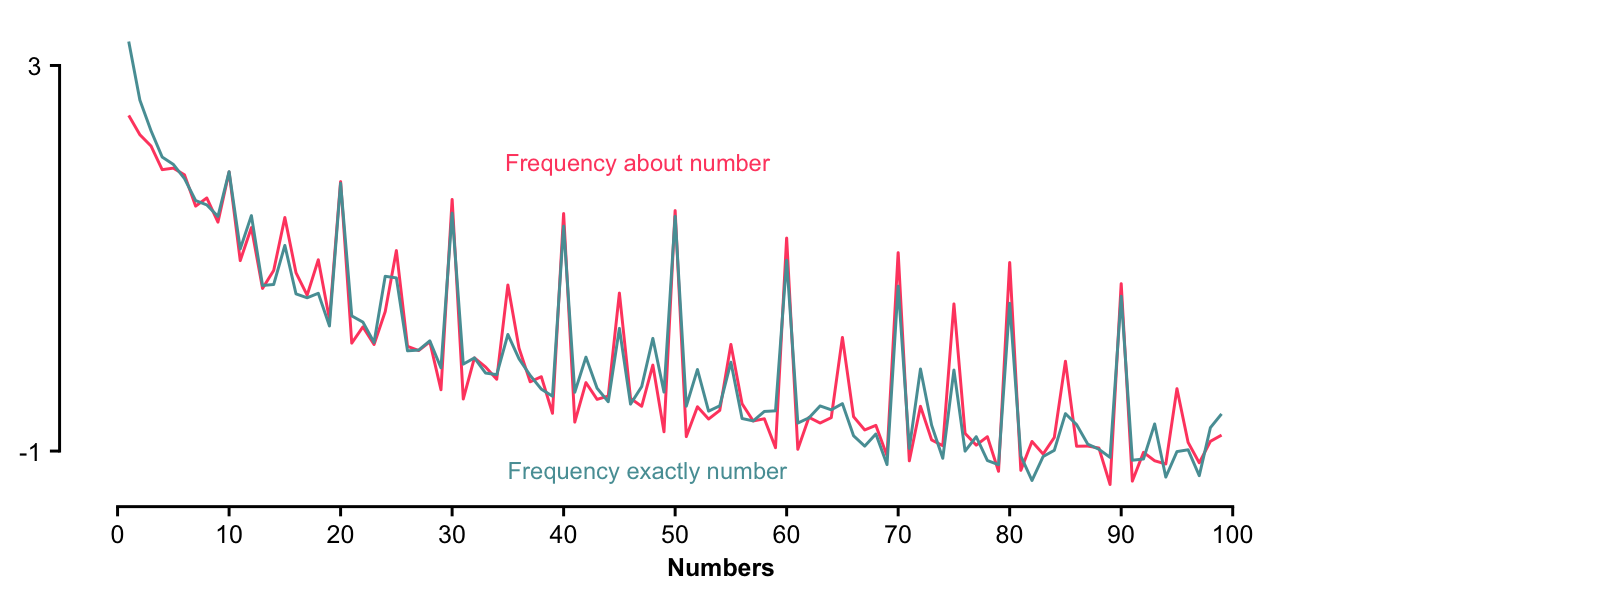

In [13]:
%%R  -w 8 -h 3 --units in -r 200

plsup1 <- read.csv('temp.csv') %>%
    ggplot(aes(x = number)) +
    geom_line(aes(y = log_freq_about_normalized, color='line'),linewidth=0.5) +


    geom_line(
    aes(y = log_freq_exactly_normalized, color='point'), linewidth=0.5) +
    geom_text(data = . %>% filter(number == 30), 
            aes(x = number, y = 2, label = 'Frequency about number', color = 'line'), 
            hjust = -0.2, size = 3) +   # Label for first line
    geom_text(data = . %>% filter(number == 30), 
            aes(x = number, y = -1.2, label = 'Frequency exactly number', color = 'point'), 
            hjust = -0.2, size = 3) +   # Label for second line
    theme(legend.position = "none",
            axis.title.y=element_blank(),
            panel.grid.major.y = element_blank(),
            axis.title.x = element_text(face="bold", size=9, hjust=0.43, family='Arial')) +
    labs(x = "Numbers") +
    scale_color_manual(values=moma.colors("Klein")) +
    xlim(1,125) +
    guides(x = guide_axis_manual(trunc_lower=0, trunc_upper=100, breaks=seq(0,100,10)),
            y = guide_axis_manual(trunc_lower=-1, trunc_upper=3, breaks=c(-1,3)))


# ggsave("plots/S1_corrected_vs_uncorrected_option1.svg", plsup1, device='svg',width = 8, height = 3, units = "in")

plsup1

In [11]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
plus_ones = []
plus_twos = []
plus_threes = []
multiples_10 = [10*i - 1  for i in range(1, 10)]
multiples_10_plus_one = [i + 1 for i in multiples_10]
multiples_10_plus_two = [i + 2 for i in multiples_10]
multiples_10_plus_three = [i + 3 for i in multiples_10]
languages = ['en','fr', 'de', 'es', 'ru', 'mean']

for lang in languages:
    df = data[data.lang.isin([lang])]
    y = np.array(df['log_freq'])

    plus_ones.append(y[multiples_10_plus_one])
    plus_twos.append(y[multiples_10_plus_two])
    plus_threes.append(y[multiples_10_plus_three])
    

In [12]:
ones = np.concatenate(plus_ones)
twos = np.concatenate(plus_twos)
threes = np.concatenate(plus_threes)

In [13]:
threes.shape

(54,)

In [14]:
t_stat1v2, p_value1v2 = stats.ttest_1samp(twos - ones, popmean=0)
t_stat1v3, p_value1v3 = stats.ttest_1samp(threes - ones, popmean=0)
print(f't = {t_stat1v2}, p = {p_value1v2}')
print(f't = {t_stat1v3}, p = {p_value1v3}')


t = 12.756131087959433, p = 8.744133072907994e-18
t = 3.2215288321103155, p = 0.0021814016710127947


# Regressing out the number of characters

In [4]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')

df = data[data.lang.isin(['en'])]


In [6]:
df['number_of_characters'] = df['matched_word'].apply(len)

/var/folders/ww/jwc_dkyx4_58jw9lnh79r69r0000gn/T/ipykernel_1965/2227255999.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_characters'] = df['matched_word'].apply(len)


In [7]:
df

,Unnamed: 0,number,lang,word,mean_freq,matched_word,mean_dash_freq,has_dash,mean_total_freq,corrected_total_freq,...,mult5,mult3,mult2,exp2,exp3,exp5,exp7,exp10,log10,number_of_characters
0,0,1,en,one,1572.145498,one,0.000000e+00,False,1572.145498,1565.268513,...,0,0,0,0,0,0,0,0,0.000000,3
1,1,2,en,two,906.184978,two,0.000000e+00,False,906.184978,899.070991,...,0,0,1,1,0,0,0,0,0.301030,3
2,2,3,en,three,441.677907,three,0.000000e+00,False,441.677907,436.484044,...,0,1,0,0,1,0,0,0,0.477121,5
3,3,4,en,four,235.432872,four,0.000000e+00,False,235.432872,227.026417,...,0,0,1,2,0,0,0,0,0.602060,4
4,4,5,en,five,191.527712,five,0.000000e+00,False,191.527712,173.590005,...,1,0,0,0,0,1,0,0,0.698970,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,94,95,en,ninety-five,0.367587,ninety - five,1.510649e-08,True,0.367587,0.367587,...,1,0,0,0,0,1,0,0,1.977724,13
95,95,96,en,ninety-six,0.255101,ninety - six,1.113704e-08,True,0.255101,0.255101,...,0,1,1,5,1,0,0,0,1.982271,12
96,96,97,en,ninety-seven,0.169779,ninety - seven,8.843187e-09,True,0.169779,0.169779,...,0,0,0,0,0,0,0,0,1.986772,14
97,97,98,en,ninety-eight,0.193553,ninety - eight,1.000961e-08,True,0.193553,0.193553,...,0,0,1,1,0,0,2,0,1.991226,14


In [10]:
data = pd.read_csv('data_ngram_allLangsPerMilion.csv')
df = data[data.lang.isin(['en'])]
df['number_of_characters'] = df['matched_word'].apply(len)
y = np.array(df['log_freq'])
X1 = np.array(df['number_of_characters'])
X1 = sm.add_constant(X1)
model1 = sm.OLS(y, X1).fit()
print(model1.summary())
residuals = model1.resid

X2 = np.array(df[['log10', 'mult2', 'mult3','mult5', 'mult10']])
X2 = sm.add_constant(X2)

model2 = sm.OLS(residuals, X2).fit()
predictions2 = model2.predict(X2)
R22 = model2.rsquared
print(model2.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.784
Model:                            OLS   Adj. R-squared:                  0.781
Method:                 Least Squares   F-statistic:                     351.2
Date:                Mon, 27 Jan 2025   Prob (F-statistic):           5.28e-34
Time:                        11:50:05   Log-Likelihood:                -55.215
No. Observations:                  99   AIC:                             114.4
Df Residuals:                      97   BIC:                             119.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.7896      0.143     19.576      0.0

/var/folders/ww/jwc_dkyx4_58jw9lnh79r69r0000gn/T/ipykernel_1965/1435280888.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['number_of_characters'] = df['matched_word'].apply(len)
